In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np

<h2 style='color:blue;'>Завантажимо останні дані:</h2>

In [6]:
url_file = 'https://github.com/pruhlo/Reservation_test/blob/master/Importing-cleaning-data/d_f_feature.xlsx?raw=true'
df = pd.read_excel(url_file, index_col=0)

<h2 style='color:blue;'> Згрупуємо дані по дням </h2>

In [7]:
df['date'] = pd.to_datetime(df.request_date_time)
data = df.groupby(pd.Grouper(key='date', freq='D')).sum()

C:\Users\GbreH\AppData\Local\Temp\ipykernel_12916\3319983986.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = df.groupby(pd.Grouper(key='date', freq='D')).sum()


<h2 style='color:blue;'> Подивимость на наявність сезонності даних </h2>

### Не знаю на скільки важливо позбавитись сезонності за умов застосування даного алгоритму

In [8]:
# Залишимо дату замовлення та кількість замовлених авто
d_f = data['booking_status'].to_frame()

Критерій Дікі-Фуллера: p=0.0137


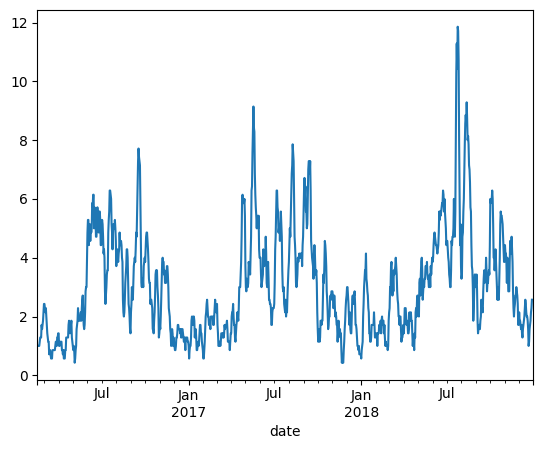

In [9]:
# Якщо p-value цього критерію менше, ніж 𝛼=0.05, то ряд стаціонарний.
print(f'Критерій Дікі-Фуллера: p={sm.tsa.stattools.adfuller(d_f)[1]:.4f}')
sm.tsa.seasonal_decompose(d_f).trend.plot()
plt.show()

<h2 style='color:blue;'> Формую залежну та незалежну змінні </h2>

In [10]:
X = data.drop('booking_status', axis=1) 
y = data['booking_status']

<h2 style='color:blue;'> Розподіл на тестовий та набір для навчання </h2>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<h2 style='color:blue;'> Регресійний алгоритм xgboost </h2>

In [12]:
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

C:\Users\GbreH\Desktop\reservation_test\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

<h2 style='color:blue;'> Оцінка моделі </h2>

In [13]:
preds = model.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='micro', zero_division=0)))
print("Recall = {}".format(recall_score(y_test, best_preds, average='micro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.12380952380952381
Recall = 0.12380952380952381
Accuracy = 0.12380952380952381


<h1 style='color:green;'>Побудуємо модель позбувшись сезонності </h1>

<h2 style='color:green;'>Лог трансформація </h2>

### (так як у наших даних присутні нулі ДОДАЄМО одиницю)

In [14]:
data_plus_one = data+1

In [15]:
log_data = data_plus_one.applymap(lambda x : np.log(x))

C:\Users\GbreH\AppData\Local\Temp\ipykernel_12916\2112620288.py:1: RuntimeWarning: invalid value encountered in log
  log_data = data_plus_one.applymap(lambda x : np.log(x))
C:\Users\GbreH\AppData\Local\Temp\ipykernel_12916\2112620288.py:1: RuntimeWarning: divide by zero encountered in log
  log_data = data_plus_one.applymap(lambda x : np.log(x))


<h2 style='color:green;'>Подивимость на наявність сезонності трансформованих даних</h2>

In [16]:
ldf = log_data['booking_status'].to_frame()

Критерій Дікі-Фуллера: p=0.0168


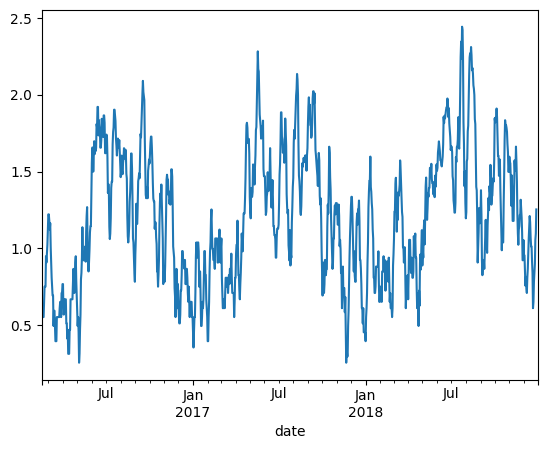

In [17]:
print(f'Критерій Дікі-Фуллера: p={sm.tsa.stattools.adfuller(ldf)[1]:.4f}')
sm.tsa.seasonal_decompose(ldf).trend.plot()
plt.show()

In [18]:
log_data_shift = log_data.shift(12)

In [19]:
stationary_df = log_data - log_data_shift

In [20]:
sdf = stationary_df['booking_status'].to_frame()

Критерій Дікі-Фуллера: p=0.0000


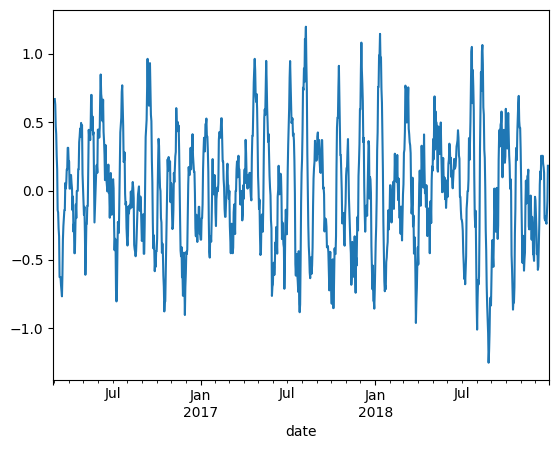

In [21]:
print(f'Критерій Дікі-Фуллера: p={sm.tsa.stattools.adfuller(sdf[12:])[1]:.4f}')
sm.tsa.seasonal_decompose(sdf[12:]).trend.plot()
plt.show()

<h2 style='color:green;'>Формую залежну та незалежну змінні</h2>

In [22]:
X = stationary_df[12:].drop(['booking_status'], axis=1) 
y = stationary_df[12:]['booking_status']

In [23]:
X = X.drop(['high_temp', 'low_temp',], axis=1) # удаляємо 'low_temp, high_temp' так як після трансформації місять NaN  та inf 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<h2 style='color:green;'> Регресійний алгоритм xgboost </h2>

In [25]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

C:\Users\GbreH\Desktop\reservation_test\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

<h2 style='color:red;'> Щось зробив не так як треба, не можу оцінити отримані дані: </h2>

In [27]:
# from sklearn.metrics import precision_score, recall_score, accuracy_score
# import numpy as np
# preds = model.predict(X_test)
# best_preds = np.asarray([np.argmax(line) for line in preds])

# print("Precision = {}".format(precision_score(y_test, best_preds, average='micro', zero_division=0)))
# print("Recall = {}".format(recall_score(y_test, best_preds, average='micro')))
# print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))